### Stock Market Prediction And Forecasting Using Stacked LSTM

###Keras and Tensorflow >2.0
### Data Collection
import pandas_datareader as pdr
key=""
df = pdr.get_data_tiingo('AAPL', api_key=key)
df.to_csv('AAPL.csv')


Starting with local csv file , reading nd displaying the first five records


In [1]:
import pandas as pd
df=pd.read_csv('AAPL.csv')
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0



Taking the Close column as dataframe


In [2]:
df1=df.reset_index()['close']
df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64


Plotting the closing price on Y-axis ,record number on X-Axis with matplotlib


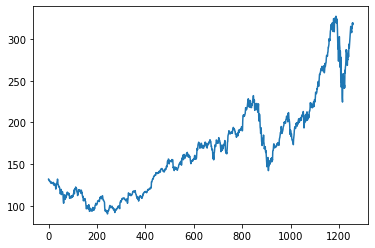

In [3]:
import matplotlib.pyplot as plt
plt.plot(df1)


LSTM are sensitive to the scale of the data. so we apply MinMax scaler which transforms the input (closing price) to 0 to 1 range values


In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])


Now we split the input data into Training (65%) and Testing Data (35%) and display the training and testing size


In [5]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size,test_size

(817, 441)


Now we convert the Training Data and Testing Data into Sequential Format with correct output

time_step => number of previous days closing prices which would contribute to next closing price

Ex: If the closing price array is 1 2 3 4
if we use time_step = 2 the output would be:
[[1,2], [2,3]] , [3, 4]

which means input features , output value:
 1 2 --> 3
 2 3 --> 4

We Convert both Train and Test Data into the above format and display the shape

In [6]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [10]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)


We convert the training and testing input to LSTM required format [samples, time steps, features]


In [11]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


Importing tensorflow and enabling GPU usage


In [12]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)


Importing keras
Creating a Sequential model with 4 layers (3 LSTM and 1 Dense)
Displaying the model summary

In [13]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________



Training the model


In [14]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 1s 69ms/step - loss: 0.0226 - val_loss: 0.0752
Epoch 2/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 3/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0074
Epoch 4/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 5/100
12/12 [==============================] - 0s 12ms/step - loss: 6.9426e-04 - val_loss: 0.0054
Epoch 6/100
12/12 [==============================] - 0s 12ms/step - loss: 6.2246e-04 - val_loss: 0.0040
Epoch 7/100
12/12 [==============================] - 0s 12ms/step - loss: 6.1208e-04 - val_loss: 0.0040
Epoch 8/100
12/12 [==============================] - 0s 12ms/step - loss: 6.0421e-04 - val_loss: 0.0039
Epoch 9/100
12/12 [==============================] - 0s 14ms/step - loss: 6.0044e-04 - val_loss: 0.0038
Epoch 10/100
12/12 [==============================] - 0s 13ms/step - loss: 6.133

12/12 [==============================] - 0s 13ms/step - loss: 2.8115e-04 - val_loss: 0.0012
Epoch 80/100
12/12 [==============================] - 0s 12ms/step - loss: 2.3700e-04 - val_loss: 0.0011
Epoch 81/100
12/12 [==============================] - 0s 12ms/step - loss: 2.2645e-04 - val_loss: 0.0012
Epoch 82/100
12/12 [==============================] - 0s 12ms/step - loss: 2.2464e-04 - val_loss: 0.0011
Epoch 83/100
12/12 [==============================] - 0s 12ms/step - loss: 2.1938e-04 - val_loss: 0.0012
Epoch 84/100
12/12 [==============================] - 0s 14ms/step - loss: 2.2783e-04 - val_loss: 0.0011
Epoch 85/100
12/12 [==============================] - 0s 13ms/step - loss: 2.3109e-04 - val_loss: 0.0011
Epoch 86/100
12/12 [==============================] - 0s 14ms/step - loss: 2.6370e-04 - val_loss: 0.0022
Epoch 87/100
12/12 [==============================] - 0s 12ms/step - loss: 2.3628e-04 - val_loss: 0.0011
Epoch 88/100
12/12 [==============================] - 0s 14ms/step -


Evaluating model performance:

We use the model to predict closing price values on training and testing data
We convert the predicted values back to original price format from min max 0 to 1 and calculate the RMSE for train and test data


In [15]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [16]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [17]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(y_train,train_predict))

141.49597077084172

In [18]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

235.91427277481296


Visualization:
Now we plot the predicted values along with actual price value to visualize the performance of the model


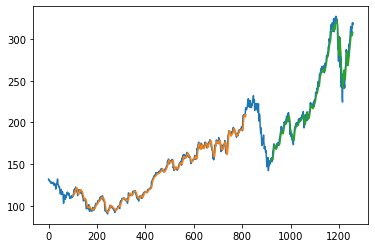

In [19]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [32]:
len(test_data)

441

In [33]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 100)

In [34]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [35]:
temp_input

[0.8583551465000423,
 0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415,
 0.933040614709111,
 0.9495060373216249,
 0.9642404796082076,
 0.9551211686228154,
 0.9598919192772104,
 0.9663514312251966,
 0.9624672802499368,
 0.9229502659799038,
 0.9598497002448705,
 0.9879253567508233,
 0.985941062230854,
 0.9253145317909315,
 0.9217259140420504,
 0.964747107996285,
 0.9757240564046274,
 0.9915984125643842,
 0.9697289538123788,
 0.9761462467280253,
 0.9679557544541082,
 1.0000000000000002,
 0.9901629654648318,
 0.9905007177235499,
 0.9653803934813816,
 0.9848855864223593,
 0.9708688676855528,
 0.9402600692392133,
 0.8774803681499621,
 0.8348391454867856,
 0.8541332432660644,
 0.7733682344000676,
 0.7726927298826314,
 0.8801401671873683,
 0.8400743054969182,
 0.8967322468969012,
 0.8552731571392387,
 0.8388499535590646,
 0.7423372456303303,
 0.82327113062568

In [36]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[1.0016491]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.9

10 day output [[1.1840708]]
11 day input [0.94950604 0.96424048 0.95512117 0.95989192 0.96635143 0.96246728
 0.92295027 0.9598497  0.98792536 0.98594106 0.92531453 0.92172591
 0.96474711 0.97572406 0.99159841 0.96972895 0.97614625 0.96795575
 1.         0.99016297 0.99050072 0.96538039 0.98488559 0.97086887
 0.94026007 0.87748037 0.83483915 0.85413324 0.77336823 0.77269273
 0.88014017 0.84007431 0.89673225 0.85527316 0.83884995 0.74233725
 0.82327113 0.78143207 0.6665963  0.7921557  0.64118044 0.68614371
 0.66001013 0.65203074 0.58642236 0.56586169 0.66089673 0.65515494
 0.70970193 0.66452757 0.69437642 0.69218104 0.63569197 0.65266402
 0.63780292 0.7267162  0.71388162 0.74191506 0.75002111 0.77222832
 0.83049059 0.8194292  0.8289707  0.8125475  0.78776492 0.75162543
 0.78426074 0.77974331 0.81326522 0.8141096  0.79473106 0.83336148
 0.85898843 0.83901883 0.85628641 0.87486279 0.88782403 0.90095415
 0.92793211 0.948535   0.93333615 0.91746179 0.92544119 0.91771511
 0.9483239  0.9406400

20 day output [[1.3266344]]
21 day input [0.92531453 0.92172591 0.96474711 0.97572406 0.99159841 0.96972895
 0.97614625 0.96795575 1.         0.99016297 0.99050072 0.96538039
 0.98488559 0.97086887 0.94026007 0.87748037 0.83483915 0.85413324
 0.77336823 0.77269273 0.88014017 0.84007431 0.89673225 0.85527316
 0.83884995 0.74233725 0.82327113 0.78143207 0.6665963  0.7921557
 0.64118044 0.68614371 0.66001013 0.65203074 0.58642236 0.56586169
 0.66089673 0.65515494 0.70970193 0.66452757 0.69437642 0.69218104
 0.63569197 0.65266402 0.63780292 0.7267162  0.71388162 0.74191506
 0.75002111 0.77222832 0.83049059 0.8194292  0.8289707  0.8125475
 0.78776492 0.75162543 0.78426074 0.77974331 0.81326522 0.8141096
 0.79473106 0.83336148 0.85898843 0.83901883 0.85628641 0.87486279
 0.88782403 0.90095415 0.92793211 0.948535   0.93333615 0.91746179
 0.92544119 0.91771511 0.9483239  0.94064004 0.96635143 0.9563033
 0.96491598 1.00164914 1.01666188 1.03562307 1.05627942 1.07713366
 1.09741473 1.11677146 1.

In [37]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [38]:
import matplotlib.pyplot as plt

In [39]:
len(df1)

1258

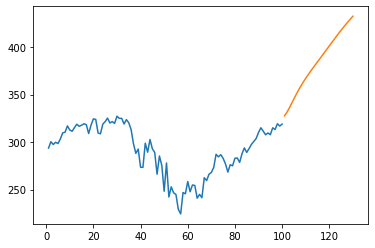

In [40]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

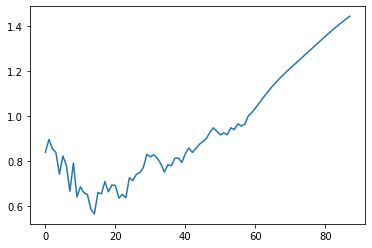

In [41]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [42]:
df3=scaler.inverse_transform(df3).tolist()

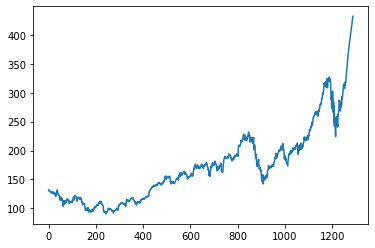

In [43]:
plt.plot(df3)